In [124]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from IPython.core.display import display, HTML
print "... python loaded"

f = open('headerlist.txt', 'r')
headerlist = f.read().rstrip('\n').split(',')
droplist = pd.read_csv('drop.txt', dtype='unicode', names=['name', 'action', 'type'])
keeplist = droplist[droplist.action == 'keep']
droplist = droplist[droplist.action == 'drop']['name'].tolist()

data = pd.read_csv('correlatesofstatepolicyprojectv1_10.csv', dtype='unicode', names=headerlist, encoding = 'utf8')
data.drop(0, inplace=True) # header row
data = data[data.st != 'DC'] # taking DC out of the data, because so much of it is missing
data = data[data.st != 'NE'] # taking Nebraska out of the data, because the political distributions are missing

print "... data ready"


def policy_table(policy, action):
    data[policy] = data[policy].astype('float')
    cs = data[['year', 'st', policy]]
    if action == 'adoption':
        policy_table = cs[cs[policy] == 1].groupby('st').nth(0).head(1000).sort_values('year')
    elif action == 'repeal':
        policy_table = cs[cs[policy] == 1].groupby('st').last().head(1000).sort_values('year')
    policy_table.reset_index(inplace=True)
    return policy_table

def numeric_pivot(c):
    table = data[['st', 'year', c]]
    ptable = table.pivot(index='year', columns='st', values=c)
    ptable=ptable.dropna(how='any',axis=0)
    ptable = ptable.astype('float')
    ptable['national_average'] = ptable.mean(axis=1)
    return ptable

def browntext(text):
    display (HTML("<font color=\"brown\">"+text+"</fond>"))

print "... subroutines available"

# Which columns show policy actions?
policy_actions = keeplist[keeplist.type == 'bin']
num_bin_policies = len(policy_actions)

numeric_indicators = keeplist[keeplist.type == 'num']
num_num = len(numeric_indicators)

print "... data separated"

for state in data.st.unique():
    #for pa in policy_actions.name:
    for pa in ['income_taxes']:
        if data[pa][data.st == state].count() > 0: # skipping columns that have no data at all
            data[pa]\
                 .iloc[data[pa][data.st == state].first_valid_index()\
                      :data[pa][data.st == state].last_valid_index() - 1]\
                                  .fillna(method='ffill', inplace=True)

for state in data.st.unique():
    data['popfemale']\
         .iloc[data['popfemale'][data.st == state].first_valid_index()\
              :data['popfemale'][data.st == state].last_valid_index() + 1]\
                     .fillna(method='ffill', inplace=True)

for state in data.st.unique():
    for pa in ['hs_rep_in_sess', 'hs_dem_in_sess', 'incshare_top10', 'incshare_top001', 'poptotal']:
        if data[pa][data.st == state].count() > 0: # skipping columns that have no data at all
            data[pa]\
             .iloc[data[pa][data.st == state].first_valid_index()\
                  :data[pa][data.st == state].last_valid_index()]\
                                  .fillna(method='ffill', inplace=True)

print "... data cleaned "

... python loaded
... data ready
... subroutines available
... data separated
... data cleaned 


In [131]:
# share of income going to the top 10% by state
top10 = numeric_pivot('incshare_top10')

# share of income going to the top 5% by state
top5 = numeric_pivot('incshare_top5')

# share of income going to the top 1% by state
top1 = numeric_pivot('incshare_top1')

# share of income going to the top 10% by state minus the top 1%
princes = top10 - top1

# share of income going to the top 10% by state minus the top 5%
dukes = top10 - top5

titles = ['gilded - top 1%', \
          'power suit - top 10%', \
          'princes - top 10% exluding top 1%', \
          'dukes - top 10% exluding top 5%']


# population
totpop = numeric_pivot('poptotal')
normpop = (totpop - totpop.mean()) / (totpop.max() - totpop.min())

# political distribution of state house representatives
data.hs_rep_in_sess = data.hs_rep_in_sess.astype('float')
data.hs_dem_in_sess = data.hs_dem_in_sess.astype('float')
pdist = data[['st','year','hs_rep_in_sess', 'hs_dem_in_sess']]
pdist = pdist.dropna(axis=0, how='any')
pdist['chartable'] = (pdist.hs_rep_in_sess/(pdist.hs_rep_in_sess + pdist.hs_dem_in_sess))

dist = pdist.pivot(index='year', columns='st', values='chartable')
dist['national_average'] = dist.mean(axis=1)

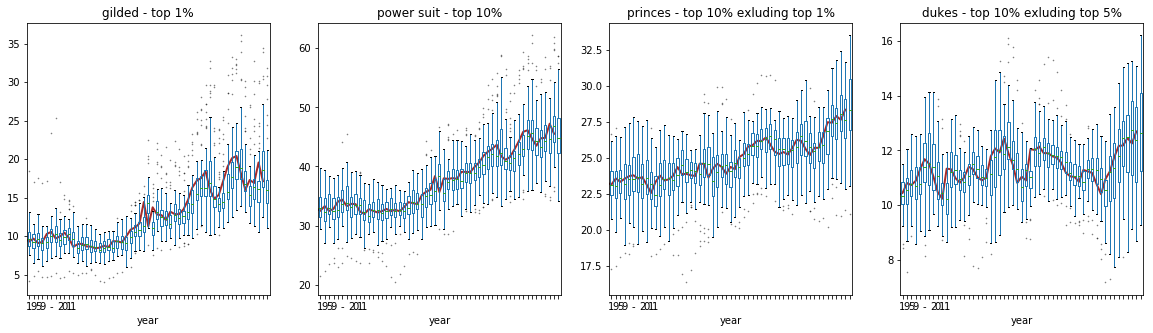

In [127]:
# plotting income shares
browntext("Percentage of state income by group")
fig, axs = plt.subplots(1,4, figsize=(20,5))
i = 0
for df in [top1, top10, princes, dukes]:
    df.national_average.plot(legend=False, ax=axs[i], color='brown', linestyle='-', linewidth=2)
    df.T.boxplot(ax=axs[i], flierprops={'alpha':0.6, 'marker': '.', 'markersize':1})
    axs[i].set_title(titles[i])
    axs[i].grid(False)
    axs[i].set_xticklabels('1959 - 2011');
    i = i + 1

    top ten gilded states =  [u'NY', u'CT', u'WY', u'NV', u'FL', u'MA', u'CA', u'TX', u'NJ', u'IL']
top ten power suit states =  [u'NY', u'CT', u'FL', u'NV', u'MA', u'CA', u'WY', u'NJ', u'MI', u'AZ']
  top ten princely states =  [u'SC', u'AZ', u'FL', u'MI', u'AL', u'OR', u'NC', u'KY', u'GA', u'NM']
      top ten duke states =  [u'SC', u'WV', u'AL', u'NM', u'AZ', u'KY', u'ME', u'MI', u'MS', u'NC']


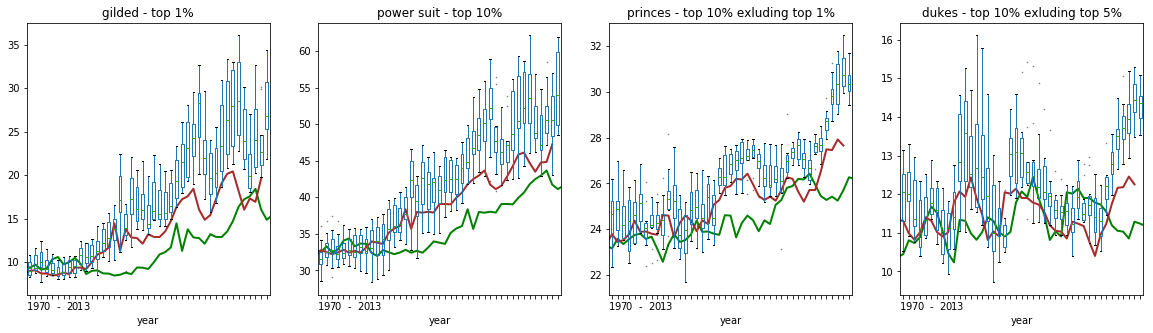

In [171]:
# pulling the top 10 states from each of the above lists as of 2013

yearlist = [str(x) for x in list(range(1970,2013))]

browntext("Same as above, but only looking at the top 10 states for each income group using rankings from 2013")
browntext("Green mean is national for these earners.  Brown mean is for this subset of states for these earners.")

print "    top ten gilded states = ", top1.T.sort_values('2013', ascending=False).index[:10].tolist()
print "top ten power suit states = ", top10.T.sort_values('2013', ascending=False).index[:10].tolist()
print "  top ten princely states = ", princes.T.sort_values('2013', ascending=False).index[:10].tolist()
print "      top ten duke states = ", dukes.T.sort_values('2013', ascending=False).index[:10].tolist()

t1 = top1[top1.T.sort_values('2013', ascending=False).index[:10]]
t10 = top10[top10.T.sort_values('2013', ascending=False).index[:10]]
p = princes[princes.T.sort_values('2013', ascending=False).index[:10]]
d = dukes[dukes.T.sort_values('2013', ascending=False).index[:10]]

t1.national_average = top1.national_average
t10.national_average = top10.national_average
p.national_average = princes.national_average
d.national_average = dukes.national_average
    
fig, axs = plt.subplots(1,4, figsize=(20,5))
i = 0
for df in [t1, t10, p, d]:
    df.national_average.plot(legend=False, ax=axs[i], color='green', linestyle='-', linewidth=2)
    df.national_average.loc[yearlist].plot(legend=False, ax=axs[i], color='brown', linestyle='-', linewidth=2)
    df.T[yearlist].boxplot(ax=axs[i], flierprops={'alpha':0.6, 'marker': '.', 'markersize':1})
    axs[i].set_title(titles[i])
    axs[i].grid(False)
    axs[i].set_xticklabels('1970 - 2013');
    #axs[i].set_xlabel(sl)
    i = i + 1

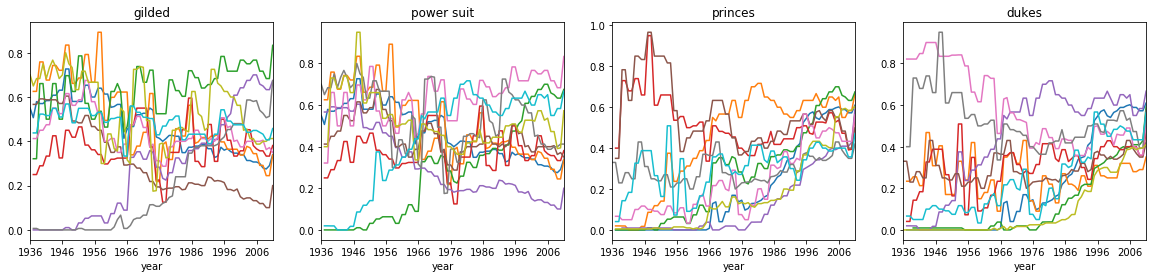

In [157]:
browntext("Percentage of republicans vs all reps in state houses for the same groups of states")
numstates = 50
t1_pol =  dist[top1.T.sort_values('2013',  ascending=False).index[:10]]
t10_pol = dist[top10.T.sort_values('2013', ascending=False).index[:10]]
p_pol = dist[princes.T.sort_values('2013', ascending=False).index[:10]]
d_pol = dist[dukes.T.sort_values('2013', ascending=False).index[:10]]

fig, axs = plt.subplots(1,4, figsize=(20,4))
t1_pol.plot(legend=False, ax=axs[0])
axs[0].set_title('gilded')

t10_pol.plot(legend=False, ax=axs[1])
axs[1].set_title('power suit')

p_pol.plot(legend=False, ax=axs[2])
axs[2].set_title('princes')

d_pol.plot(legend=False, ax=axs[3])
axs[3].set_title('dukes')


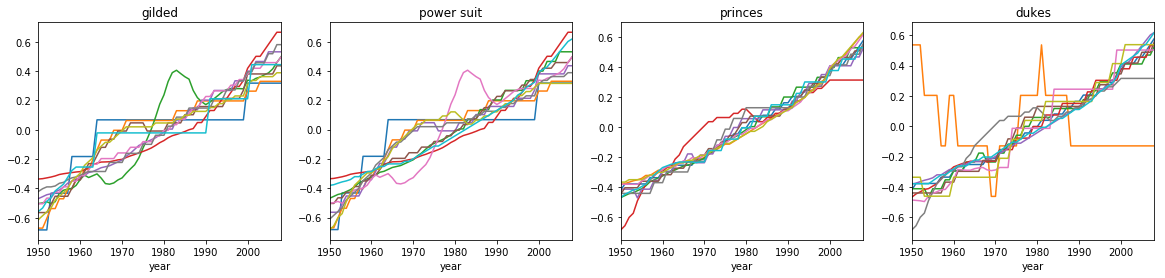

In [160]:
#normpop
browntext("Population trends for the same groups of states")
numstates = 50
t1_pol_head =  normpop[top1.T.sort_values('2013',  ascending=False).index[:10]]
t10_pol_head = normpop[top10.T.sort_values('2013', ascending=False).index[:10]]
p_pol_head = normpop[princes.T.sort_values('2013', ascending=False).index[:10]]
d_pol_head = normpop[dukes.T.sort_values('2013', ascending=False).index[:10]]

fig, axs = plt.subplots(1,4, figsize=(20,4))
t1_pol_head.plot(legend=False, ax=axs[0])
axs[0].set_title('gilded')

t10_pol_head.plot(legend=False, ax=axs[1])
axs[1].set_title('power suit')

p_pol_head.plot(legend=False, ax=axs[2])
axs[2].set_title('princes')

d_pol_head.plot(legend=False, ax=axs[3])
axs[3].set_title('dukes')


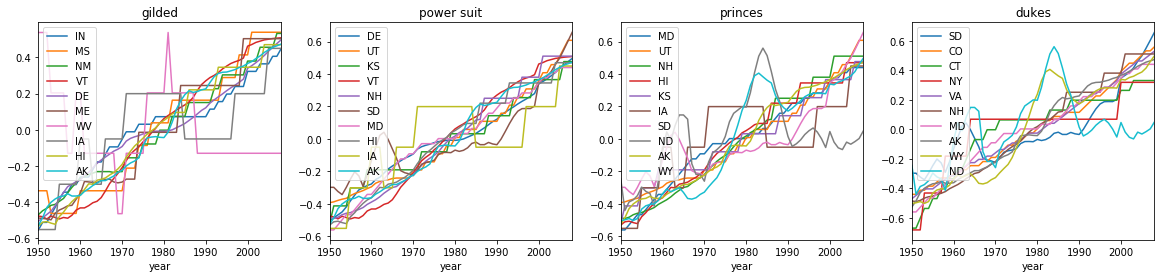

In [181]:
#normpop
browntext("Population trends for the bottom groups of states (the least unequal) in each list")
numstates = 50

t1_pol_tail =  normpop[top1.T.sort_values('2013',  ascending=False).index[40:50]]
t10_pol_tail = normpop[top10.T.sort_values('2013', ascending=False).index[40:50]]
p_pol_tail = normpop[princes.T.sort_values('2013', ascending=False).index[40:50]]
d_pol_tail = normpop[dukes.T.sort_values('2013', ascending=False).index[40:50]]

fig, axs = plt.subplots(1,4, figsize=(20,4))
t1_pol_tail.plot(legend=False, ax=axs[0])
axs[0].legend(loc="upper left")
axs[0].set_title('gilded')

t10_pol_tail.plot(legend=False, ax=axs[1])
axs[1].legend(loc="upper left")
axs[1].set_title('power suit')

p_pol_tail.plot(ax=axs[2])
axs[2].legend(loc="upper left")
axs[2].set_title('princes')

d_pol_tail.plot(ax=axs[3])
axs[3].legend(loc="upper left")
axs[3].set_title('dukes')